In [1]:
import pandas as pd
import numpy as np
import xarray as xr
import math
import matplotlib.pyplot as plt

data = xr.open_dataset("../AQ - Experiments/data/delhi_cpcb_2022.nc")
# data = xr.open_dataset("delhi_cpcb_2022.nc")
data

<xarray.Dataset>
Dimensions:    (station: 40, time: 8783)
Coordinates:
  * station    (station) object 'Alipur, Delhi - DPCC' ... 'Wazirpur, Delhi -...
  * time       (time) datetime64[ns] 2022-01-01T00:30:00 ... 2023-01-01T22:23:30
    latitude   (station) float64 ...
    longitude  (station) float64 ...
Data variables: (12/21)
    From Date  (station, time) datetime64[ns] ...
    To Date    (station, time) datetime64[ns] ...
    PM2.5      (station, time) float64 ...
    PM10       (station, time) float64 ...
    NO         (station, time) float64 ...
    NO2        (station, time) float64 ...
    ...         ...
    WD         (station, time) float64 ...
    SR         (station, time) float64 ...
    BP         (station, time) float64 ...
    AT         (station, time) float64 ...
    RF         (station, time) float64 ...
    TOT-RF     (station, time) float64 ...

In [2]:
lat_list = [28.815329,28.647622,28.695381,28.4706914,28.7762,28.7256504,28.5512005,28.656756,28.7500499,28.498571,28.5710274,28.655935,28.5627763,28.6811736,28.628624,28.73282,28.58028,28.588333,28.5918245,28.611281,28.636429,28.684678,28.60909,28.570173,28.822836,28.56789,28.6573814,28.530785,28.623763,28.674045,28.639645,28.639645,28.563262,28.732528,28.6514781,28.5504249,28.710508,28.531346,28.672342,28.699793]

In [3]:
df_ = data.to_dataframe().reset_index()
# df_ = 
df = df_[df_["time"]=="2022-03-01 01:30:00"]
df = df.dropna(subset=["PM2.5"])
df = df.rename(columns={"RH": "relative_humidity", "WS": "wind_speed", "WD": "wind_direction", "SR": "solar_radiation", "BP": "pressure", "AT": "temperature", "RF": "rain_fall", "TOT-RF": "total_rainfall"})

In [4]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['station'] = le.fit_transform(df['station'])

In [5]:
station = {}
lat = []
long = []
for i in df.station.unique():
    lat_i = df[df['station'] == i]['latitude'].item()
    long_i = df[df['station'] == i]['longitude'].item()
    pm_i = df[df['station'] == i]['PM2.5'].item()
    
    station[i] = [lat_i, long_i, pm_i]
    long.append(long_i)
    lat.append(lat_i)

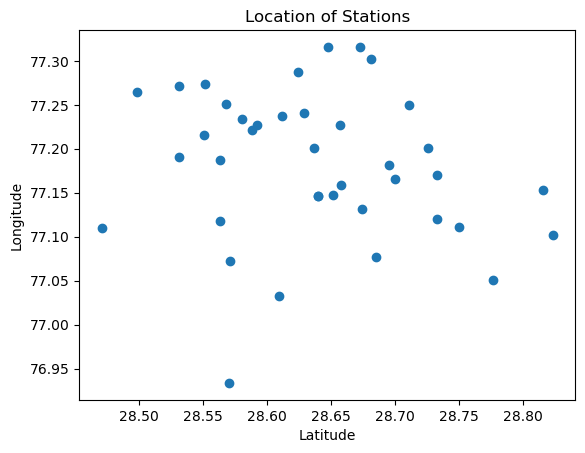

In [6]:
plt.scatter(y = long, x = lat)
plt.title('Location of Stations')
plt.ylabel('Longitude')
plt.xlabel('Latitude')
plt.show()

In [7]:
import math

def get_distance(lat1, lon1, lat2, lon2):
    # Calculate the distance between the coordinates using the Haversine formula
    radius = 6371  # Earth's radius in kilometers
    dlat = math.radians(lat2 - lat1)
    dlon = math.radians(lon2 - lon1)
    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    distance = radius * c
    return distance

distances = [] #Store distance between each pair of nodes
for i in station.keys():
    temp = []
    for j in station.keys():
        if i==j:
            continue
        else:
            temp.append([get_distance(station[i][0], station[i][1], station[j][0], station[j][1]), j])
    distances.append(temp)


In [8]:
for i in range(len(distances)):
    distances[i].sort()

In [9]:
import networkx as nx

distance_threshold = 1e9

# Create an empty nx graph
G = nx.Graph()

# Iterate through each node in the dataset
for i in range(len(df)):
    lat1, lon1 = df.iloc[i]['latitude'], df.iloc[i]['longitude']
    pm = df.iloc[i]['PM2.5']
    
    # Add the current node to the nx graph
    G.add_node(i, latitude=lat1, longitude=lon1, pm=pm)

    # Iterate through the remaining nodes
    for j in range(i + 1, len(df)):
        lat2, lon2 = df.iloc[j]['latitude'], df.iloc[j]['longitude']
        
        # Calculate the distance between the coordinates using the Haversine formula
        radius = 6371  # Earth's radius in kilometers
        dlat = math.radians(lat2 - lat1)
        dlon = math.radians(lon2 - lon1)
        a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
        c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
        distance = radius * c
        
        # Check if the distance is below the threshold
        if distance <= distance_threshold:
            # Add an edge between the current pair of nodes in the nx graph
            G.add_edge(i, j)



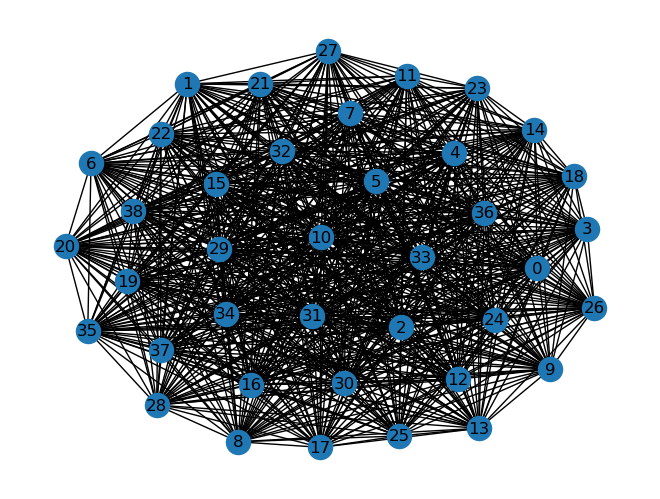

In [10]:
layout1 = nx.spring_layout(G, k=0.5)

# Draw the graph with the specified layout
plt.figure()  
nx.draw(G, pos=layout1, with_labels=True)
plt.show()

In [11]:
import random
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data, Dataset
from torch_geometric.nn import GCNConv, GATConv, SAGEConv,TransformerConv,PDNConv,SuperGATConv,GATv2Conv

#GNN
class RegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(RegressionModel, self).__init__()
        self.conv1 = GATv2Conv(input_dim, 16)
        self.linear1 = nn.Linear(16, 10)
        self.linear2 = nn.Linear(10, 1)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        # x = F.relu(x)
        # x = self.conv2(x, edge_index)
        # x = F.relu(x)
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        return x

def run_model(G):
    node_features = [(G.nodes[node]['latitude'], G.nodes[node]['longitude']) for node in G.nodes]
    edge_index = torch.tensor(list(G.edges)).t().contiguous()
    y = torch.tensor([G.nodes[node]['pm'] for node in G.nodes], dtype=torch.float).view(-1, 1)
    sorted_nodes = sorted(G.nodes(), key=lambda node: G.nodes[node]['latitude'])

    # Divide train and test masks based on the latitudes
    train_mask = torch.zeros(y.size(0), dtype=torch.bool)
    test_mask = torch.zeros(y.size(0), dtype=torch.bool)
    for i, node in enumerate(G.nodes):
        lat = G.nodes[node]['latitude']
        if lat in lat_list[:30]:
            train_mask[i] = True
        else:
            test_mask[i] = True

    data1 = Data(x=torch.tensor(node_features, dtype=torch.float), edge_index=edge_index, y=y,train_mask=train_mask, test_mask=test_mask)
    
    seed = 42
    random.seed(seed)
    torch.manual_seed(seed)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model1 = RegressionModel(input_dim=2).to(device)
    optimizer = torch.optim.Adam(model1.parameters(), lr=0.01)
    criterion = nn.MSELoss()
    
    #Train GNN
    for epoch in range(2500):
        optimizer.zero_grad()
        out = model1(data1.x.to(device), data1.edge_index.to(device))
        loss = criterion(out[data1.train_mask].squeeze(), data1.y[data1.train_mask].squeeze())
        loss.backward()
        optimizer.step()
    
    #GNN Output
    model1.eval()
    with torch.no_grad():
        out = model1(data1.x.to(device), data1.edge_index.to(device))  # Predicted PM values
        train_rmse_g = torch.sqrt(torch.mean((out[data1.train_mask].squeeze() - data1.y[data1.train_mask].squeeze())**2))
        test_rmse_g = torch.sqrt(torch.mean((out[data1.test_mask].squeeze() - data1.y[data1.test_mask].squeeze())**2))

    g_pred = out[data1.test_mask].squeeze().tolist()
    actual = data1.y[data1.test_mask].squeeze().tolist()
    
    #Mean Value
    train_mean = torch.mean(data1.y[data1.train_mask])
    mean_pred = int(data1.test_mask.sum())*[float(train_mean)]
    mean_rmse_test = torch.sqrt(torch.mean((train_mean - data1.y[data1.test_mask].squeeze())**2))
    
    #Prepare Data for LR and RF
    X_train = data1.x[data1.train_mask].numpy()
    y_train = data1.y[data1.train_mask].numpy().reshape(-1)
    X_test = data1.x[data1.test_mask].numpy()
    y_test = data1.y[data1.test_mask].numpy().reshape(-1)
    
    #Linear Regression
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    y_test_pred_lr = lr_model.predict(X_test)
    test_rmse_lr = torch.sqrt(torch.mean((torch.tensor(y_test_pred_lr) - data1.y[data1.test_mask])**2))

    #Random Forest
    rf_model = RandomForestRegressor(n_estimators=1000, random_state=42)
    rf_model.fit(X_train, y_train)
    y_test_pred_rf = rf_model.predict(X_test)
    test_rmse_rf = torch.sqrt(torch.mean((torch.tensor(y_test_pred_rf) - data1.y[data1.test_mask])**2))
    
    #KNN
    knn_model = KNeighborsRegressor(n_neighbors = 8)
    knn_model.fit(X_train, y_train)
    y_test_pred_knn = knn_model.predict(X_test)
    test_rmse_knn = torch.sqrt(torch.mean((torch.tensor(y_test_pred_knn) - data1.y[data1.test_mask])**2))
    
    return float(test_rmse_knn), float(mean_rmse_test), float(test_rmse_lr), float(test_rmse_rf), float(test_rmse_g), g_pred, y_test_pred_rf, actual, y_test_pred_lr, mean_pred, y_test_pred_knn

In [12]:
#Set Timestamps
p = pd.date_range(start='2022-02-10 01:30:00', end='2022-08-15 01:30:00', freq = '12H').to_frame(name='dates')

#Lists to store outputs
lr_rmse, g_rmse, rf_rmse, mean_rmse, knn_rmse = [], [], [], [], []
g_predictions, rf_predictions, actual_vals, lr_predictions, mean_predictions, knn_predictions = [], [], [], [], [], []

print('TIME \t\t\t RF \t\t\t G \t\t\t LR \t\t\t M \t\t\t KNN')

for i in p['dates']:
    d = df_[df_["time"]== i]
    d = d.dropna(subset=["PM2.5"])
    if len(d.station.unique()) != 39:
        continue
        
    le2 = LabelEncoder()
    d['station'] = le2.fit_transform(d['station'])
    
    for j in G.nodes:
        G.nodes[j]['pm'] = d.iloc[j]['PM2.5']
        
    knn, mean, lr, rf, g , g_pred, rf_pred, actual, lr_pred, mean_pred, knn_pred = run_model(G)
    
    print(i, '  ', rf, '  ', g, '  ', lr, '  ', mean, '  ', knn)
    
    g_predictions.append(g_pred) 
    rf_predictions.append(rf_pred)
    actual_vals.append(actual)
    lr_predictions.append(lr_pred)
    mean_predictions.append(mean_pred)
    knn_predictions.append(knn_pred)
    lr_rmse.append(lr)
    mean_rmse.append(mean)
    rf_rmse.append(rf)
    g_rmse.append(g)
    knn_rmse.append(knn)

TIME 			 RF 			 G 			 LR 			 M 			 KNN
2022-02-17 01:30:00    40.59188470141766    32.490760803222656    32.62789535522461    32.487770080566406    37.823970794677734
2022-02-17 13:30:00    19.509323163198754    16.218631744384766    16.30398178100586    16.21744155883789    18.591026306152344
2022-02-18 01:30:00    69.21147617896115    59.98017120361328    61.521942138671875    59.863853454589844    60.744449615478516
2022-02-20 13:30:00    10.167969399562859    9.022254943847656    9.094183921813965    9.006196975708008    9.518739700317383
2022-02-21 01:30:00    28.233712237142953    19.500377655029297    19.601177215576172    19.491031646728516    23.41574478149414
2022-02-21 13:30:00    20.857741026736896    19.077190399169922    19.12698745727539    19.057750701904297    20.774438858032227
2022-02-23 01:30:00    15.755524259301076    13.565013885498047    13.859313011169434    13.565038681030273    15.340324401855469
2022-02-24 01:30:00    63.096609441517145    52.27090835571289 

In [13]:
#Get Station-wise Predictions
stations_preds = []
actual_v = np.transpose(actual_vals)
g_preds = np.transpose(g_predictions)
rf_preds = np.transpose(rf_predictions)
lr_preds = np.transpose(lr_predictions)
mean_preds = np.transpose(mean_predictions)
knn_preds = np.transpose(knn_predictions)
for i in range(len(actual_v)):
    temp = [actual_v[i], g_preds[i], rf_preds[i], lr_preds[i], mean_preds[i], knn_preds[i]]
    stations_preds.append(temp)

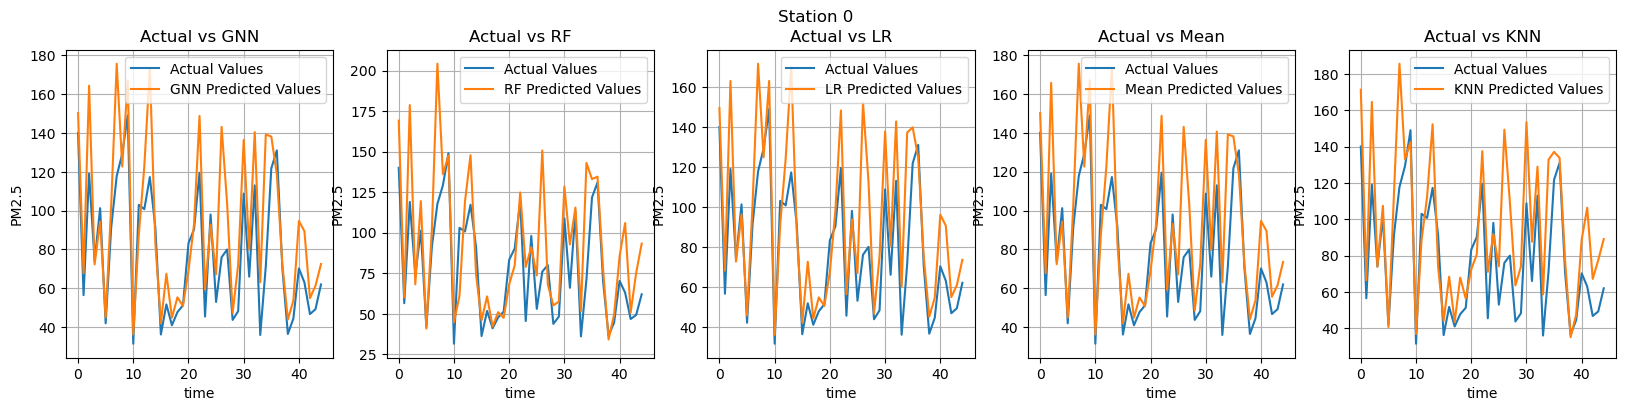

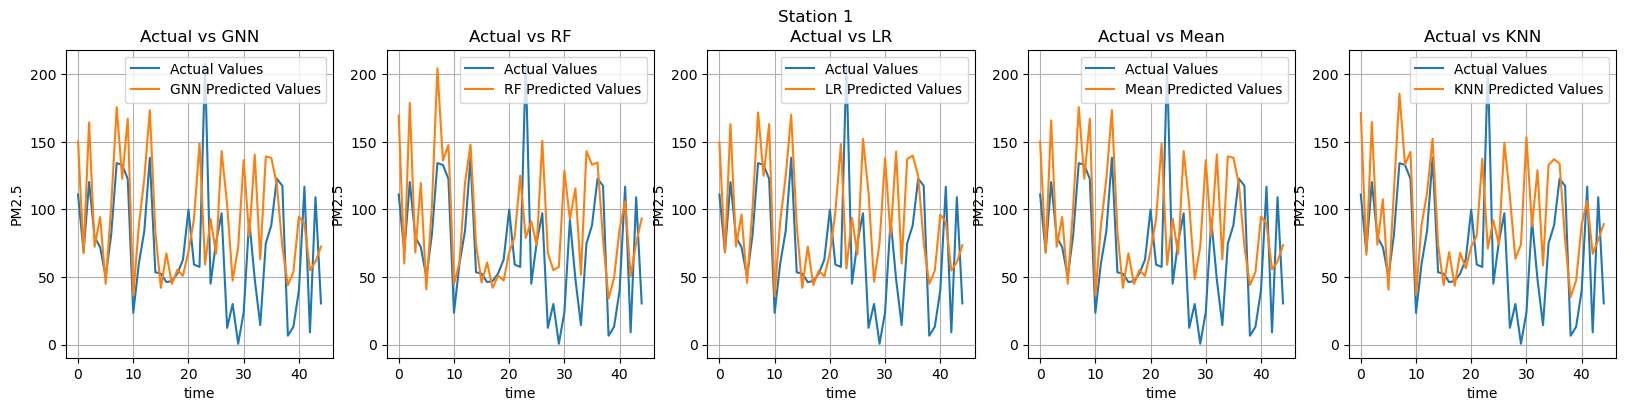

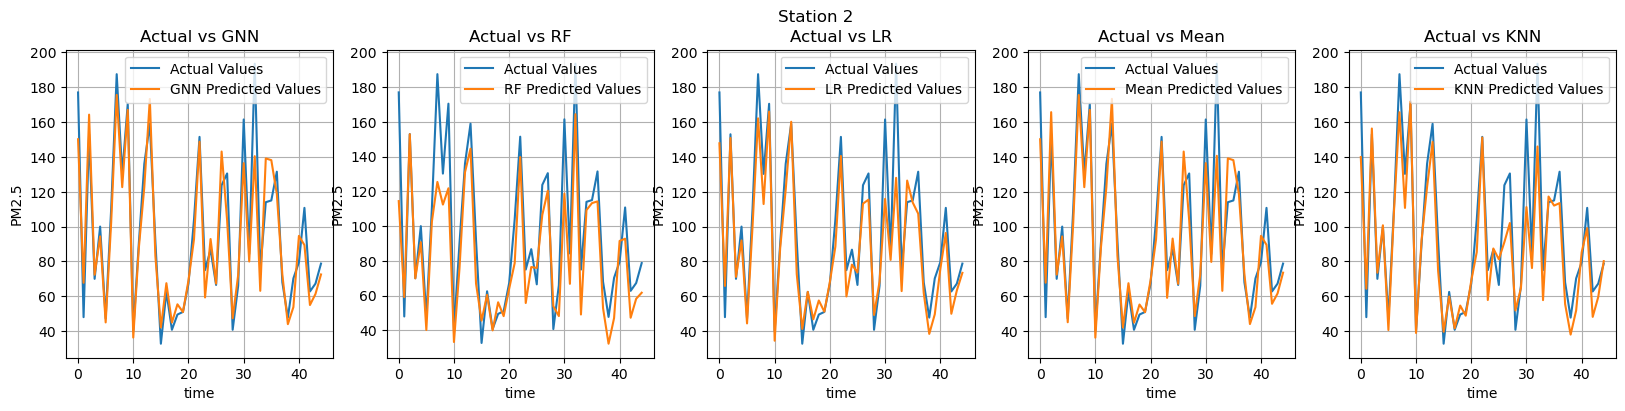

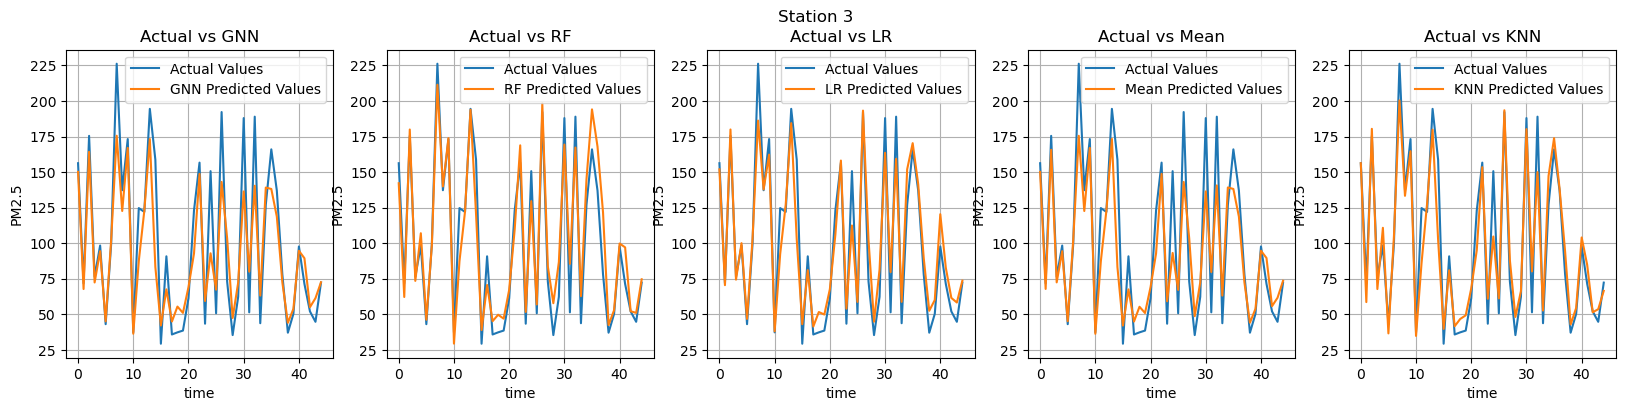

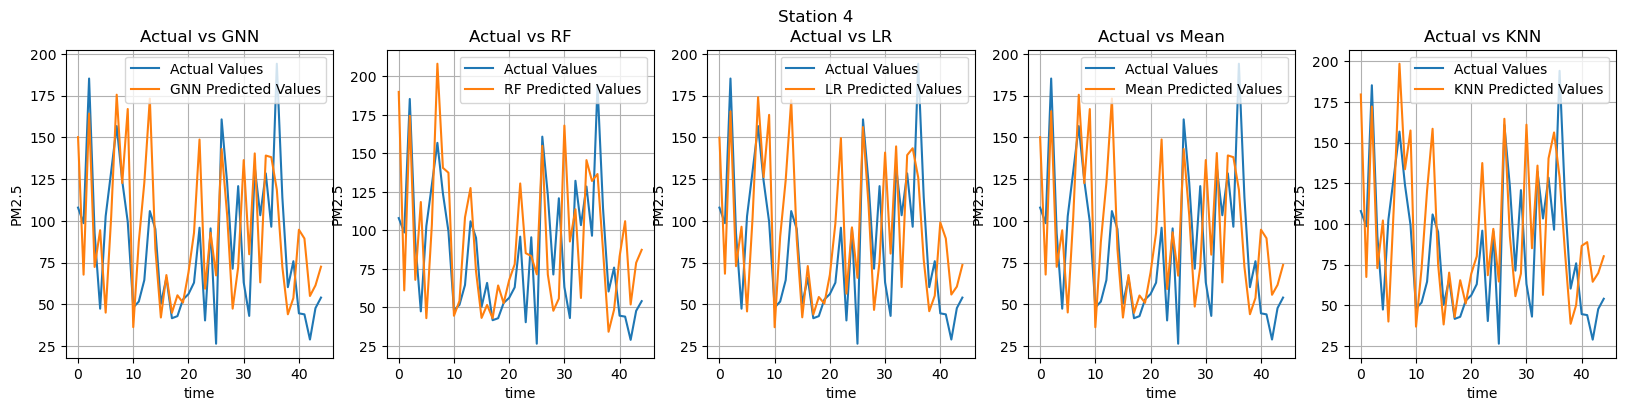

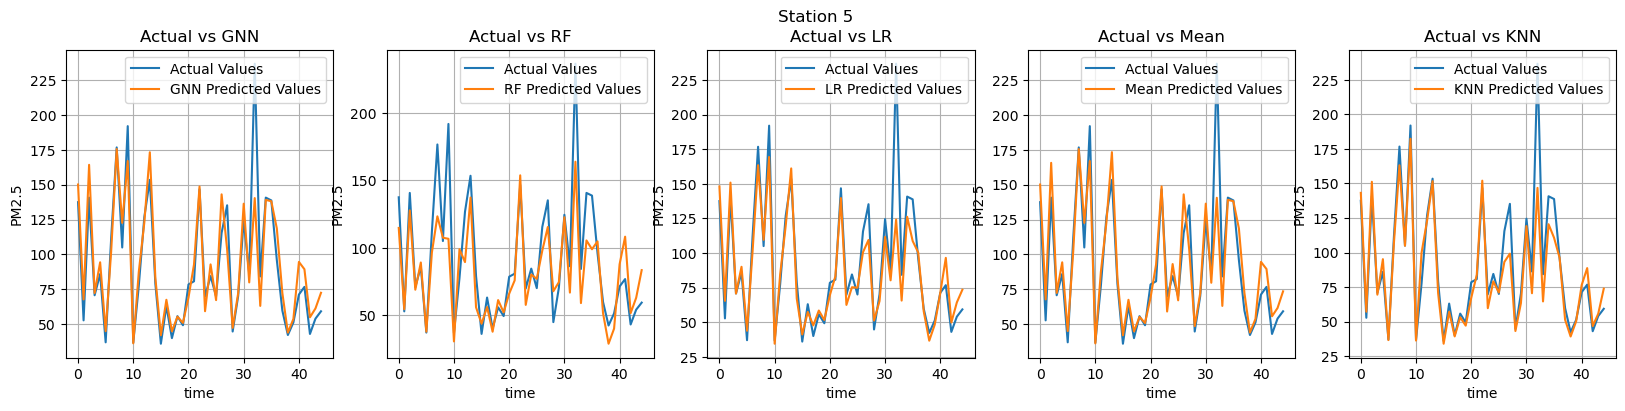

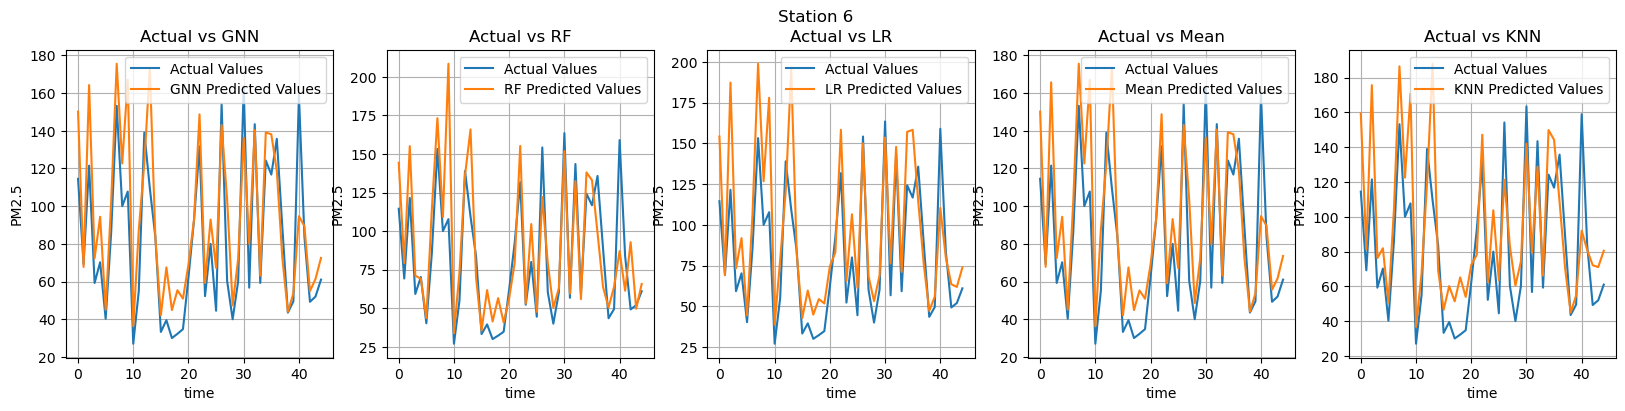

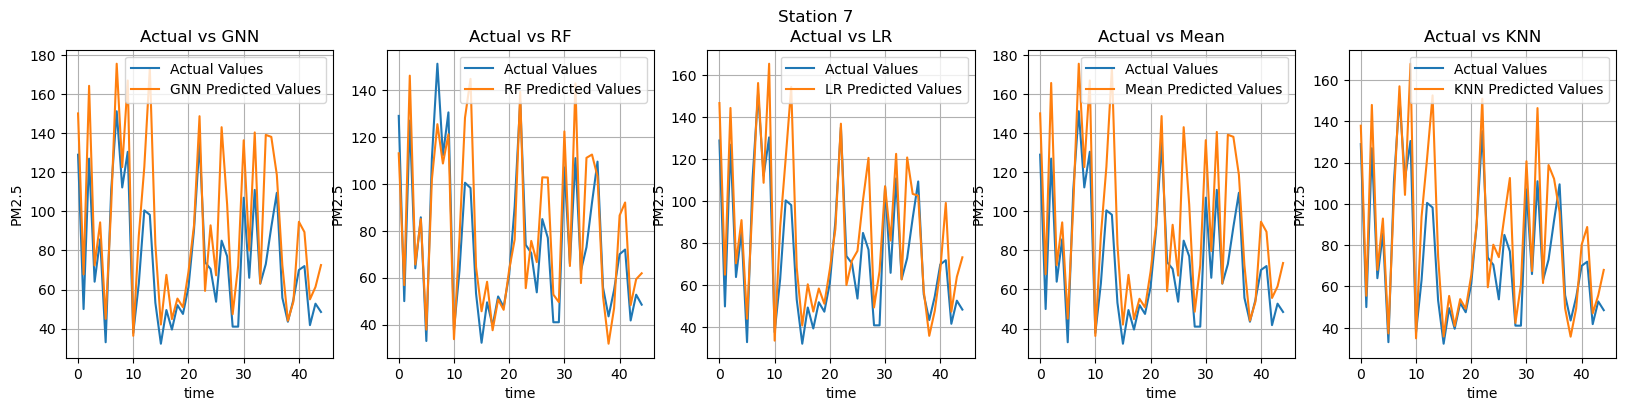

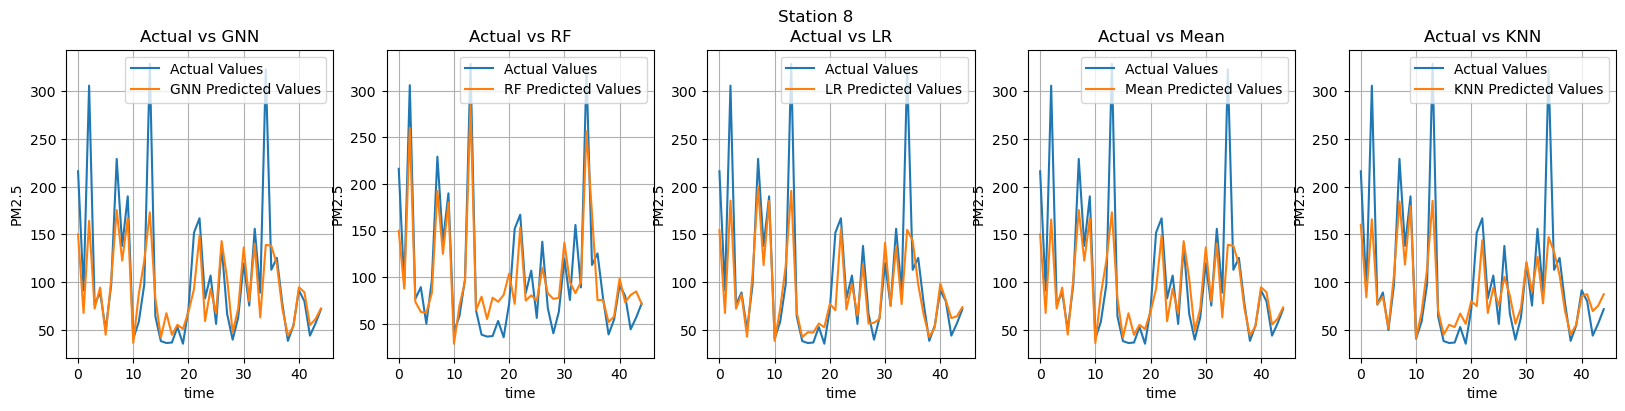

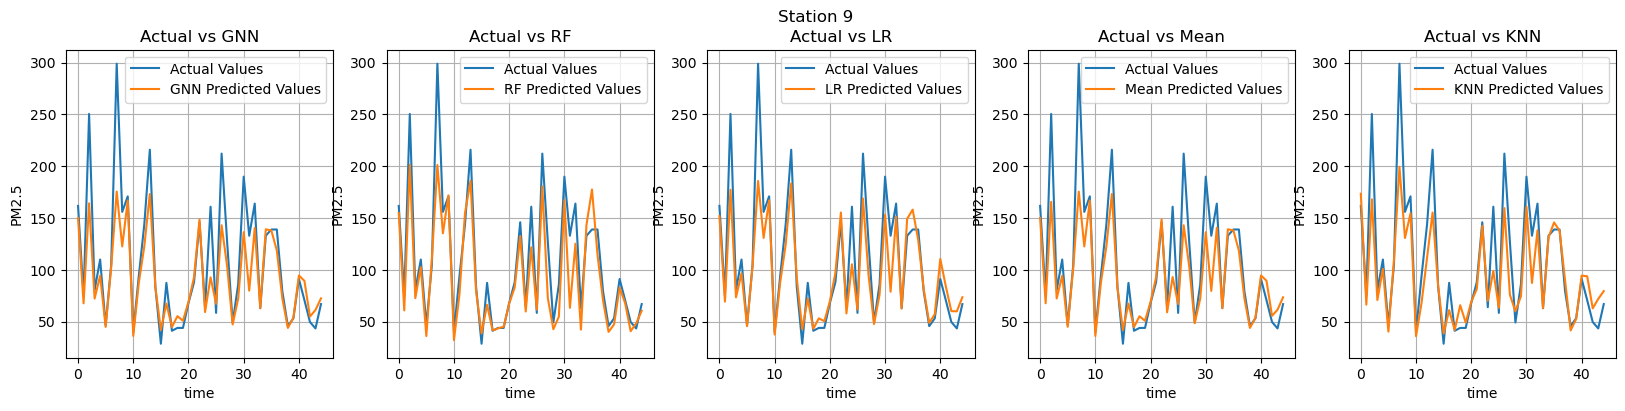

In [14]:
#Plot Station-wise predictions
for i in range(len(stations_preds)):
    plt.figure(figsize=(20,4))
    s = 'Station '+ str(i)
    plt.suptitle(s)
    plt.subplot(1, 5, 1)
    plt.plot(stations_preds[i][0], label = 'Actual Values')
    plt.plot(stations_preds[i][1], label = 'GNN Predicted Values')
    plt.title('Actual vs GNN')
    plt.ylabel('PM2.5')
    plt.xlabel('time')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 5, 2)
    plt.plot(stations_preds[i][0], label = 'Actual Values')
    plt.plot(stations_preds[i][2], label = 'RF Predicted Values')
    plt.title('Actual vs RF')
    plt.ylabel('PM2.5')
    plt.xlabel('time')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 5, 3)
    plt.plot(stations_preds[i][0], label = 'Actual Values')
    plt.plot(stations_preds[i][3], label = 'LR Predicted Values')
    plt.title('Actual vs LR')
    plt.ylabel('PM2.5')
    plt.xlabel('time')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 5, 4)
    plt.plot(stations_preds[i][0], label = 'Actual Values')
    plt.plot(stations_preds[i][4], label = 'Mean Predicted Values')
    plt.title('Actual vs Mean')
    plt.ylabel('PM2.5')
    plt.xlabel('time')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 5, 5)
    plt.plot(stations_preds[i][0], label = 'Actual Values')
    plt.plot(stations_preds[i][5], label = 'KNN Predicted Values')
    plt.title('Actual vs KNN')
    plt.ylabel('PM2.5')
    plt.xlabel('time')
    plt.legend()
    plt.grid(True)
    
    plt.show()

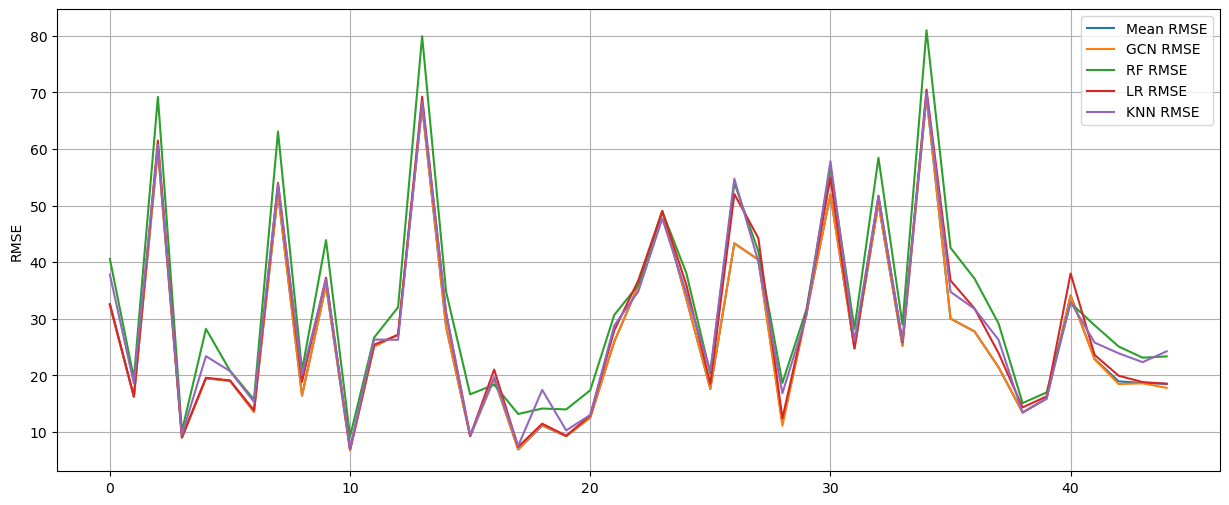

In [15]:
#PLot RMSE for Mean, GNN, RF, LR
plt.figure(figsize=(15,6))
plt.plot(mean_rmse, label = 'Mean RMSE')
plt.plot(g_rmse, label = 'GCN RMSE')
plt.plot(rf_rmse, label = 'RF RMSE')
plt.plot(lr_rmse, label = 'LR RMSE')
plt.plot(knn_rmse, label = 'KNN RMSE')
plt.ylabel('RMSE')
# plt.xlabel('time')
plt.legend()
plt.grid(True)
plt.show()

In [16]:
#Get number of times which model performs best
rf, lr, g, m, knn = 0, 0, 0, 0, 0
for i in range(len(mean_rmse)):
    if(min([knn_rmse[i], mean_rmse[i], g_rmse[i], rf_rmse[i], lr_rmse[i]]) == mean_rmse[i]):
        m+=1
    if(min([knn_rmse[i], mean_rmse[i], g_rmse[i], rf_rmse[i], lr_rmse[i]]) == g_rmse[i]):
        g+=1
    if(min([knn_rmse[i], mean_rmse[i], g_rmse[i], rf_rmse[i], lr_rmse[i]]) == lr_rmse[i]):
        lr+=1
    if(min([knn_rmse[i], mean_rmse[i], g_rmse[i], rf_rmse[i], lr_rmse[i]]) == rf_rmse[i]):
        rf+=1
    if(min([knn_rmse[i], mean_rmse[i], g_rmse[i], rf_rmse[i], lr_rmse[i]]) == knn_rmse[i]):
        knn+=1

print('No of Timestamps: ', len(mean_rmse))
print('Random Forest: ', rf)
print('Linear Regression: ', lr)
print('GNN: ', g)
print('Mean: ', m)
print('KNN: ', knn)

No of Timestamps:  45
Random Forest:  2
Linear Regression:  0
GNN:  18
Mean:  19
KNN:  6
